## > Import Packages

In [24]:
## Import packages
from scipy.io import loadmat
from sklearn import preprocessing
from tabulate import tabulate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import svm
import pandas as pd
import numpy as np
import statistics 
import math
import time
import sys

## Import DL
import keras 
from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPool2D , Conv1D, Flatten, MaxPooling1D
from keras.models import Sequential

## add - ons
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
min_max_scaler = preprocessing.MinMaxScaler()

In [25]:
## Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## > Functions

In [40]:
# scene = 'Indian_Pines' / 'PaviaU',
# type = 'Supervised' / 'unSupervised',
# n = '18' .. to ..  '25'
def load_data(scene = 'Indian_Pines', algo_type = 'Supervised', n = '25'):
  
    img_file = '/content/drive/My Drive/Major_Project/Data/' + scene + '.mat'
    img_gt_file = '/content/drive/My Drive/Major_Project/Data/' + scene + '_gt.mat'
    img_dr_file = '/content/drive/My Drive/Major_Project/' + algo_type + '_Results/' + scene + '/DR/img_f_DR_' + n + '.npy'
    img_dr_orig_file = '/content/drive/My Drive/Major_Project/' + algo_type + '_Results/' + scene + '/DR/img_orig_DR_' + n + '.npy'

    img = loadmat(img_file)
    img_gt = loadmat(img_gt_file)
    img_dr = np.load(img_dr_file)
    img_dr_orig = np.load(img_dr_orig_file)

    if scene == 'PaviaU':
        img = img['paviaU']
        gt = img_gt['paviaU_gt']
    elif scene == 'Indian_Pines':
        img = img['indian_pines_corrected']
        gt = img_gt['indian_pines_gt']
    else:
        print("scene does not exist")

    height, width, bands = img.shape[0], img.shape[1], img.shape[2]
    num_classes = len(np.unique(gt))

    #reshaping image to vector
    img = np.reshape(img, [height*width, bands])
    img_gt = np.reshape(gt, [height*width,])
    #checking background pixels - they will be omitted later from training data
    background = img_gt[img_gt == 0]

    #sanity checks
    print("Number of Label Classes: ", num_classes)
    print("Image size: ", img.shape)
    print("Reduced Image size: ", img_dr.shape)
    print("Label size: ", img_gt.shape)
    print("Background Pixels: ", background.shape)
    print("\n Class distribution: => ")
    print(tabulate(np.unique(img_gt, return_counts=True), tablefmt="grid"))
    plt.figure(1)
    plt.imshow(gt)
    plt.figure(2)
    plt.plot(img[1,])

    return img, img_gt, img_dr, img_dr_orig

In [27]:
## Preprocess

def preprocess(img, img_gt, img_dr, img_dr_orig):
    #separate foreground and background
    img_fg = img[img_gt != 0]
    img_bg = img[img_gt == 0]

    img_dr_fg = img_dr[img_gt != 0]
    img_dr_bg = img_dr[img_gt == 0]

    img_dr_orig_fg = img_dr_orig[img_gt != 0]
    img_dr_orig_bg = img_dr_orig[img_gt == 0]

    img_gt_fg = img_gt[img_gt != 0]
    img_gt_bg = img_gt[img_gt == 0]

    #shuffle data with seed 10
    shufflePermutation = np.random.RandomState(seed=10).permutation(len(img_fg))
    img_fg = img_fg[shufflePermutation]
    img_dr_fg = img_dr_fg[shufflePermutation]
    img_dr_orig_fg = img_dr_orig_fg[shufflePermutation]
    img_gt_fg = img_gt_fg[shufflePermutation]

    #define train/test split ratio
    split_ratio = 0.7
    split = math.ceil(img_fg.shape[0]*split_ratio)

    ## split into training and testing
    #orignal dimension image
    img_train = img_fg[:(split+1),:]
    img_gt_train = img_gt_fg[:(split+1)]
    img_test = img_fg[(split+1):,:]
    img_gt_test = img_gt_fg[(split+1):]
    #reduced dimension image
    img_dr_train = img_dr_fg[:(split+1),:]
    img_dr_test = img_dr_fg[(split+1):,:]
    img_dr_orig_train = img_dr_orig_fg[:(split+1),:]
    img_dr_orig_test = img_dr_orig_fg[(split+1):,:]

    #test and train distribution
    print(tabulate(np.unique(img_gt_train, return_counts=True), tablefmt="grid"))
    print(tabulate(np.unique(img_gt_test, return_counts=True), tablefmt="grid"))

    ## Normalize data
    #orignal dimension image
    img_train = preprocessing.normalize(img_train.astype('float32'))  #OR preprocessing.scale(img_train.astype('float32'))
    img_test = preprocessing.normalize(img_test.astype('float32'))
    #reduced dimension image
    img_dr_train = preprocessing.normalize(img_dr_train.astype('float32'))
    img_dr_test = preprocessing.normalize(img_dr_test.astype('float32'))
    img_dr_orig_train = preprocessing.normalize(img_dr_orig_train.astype('float32'))
    img_dr_orig_test = preprocessing.normalize(img_dr_orig_test.astype('float32'))

    ## Min-Max Scaler
    #orignal dimension image
    img_train = min_max_scaler.fit_transform(img_train.astype('float32'))
    img_test = min_max_scaler.fit_transform(img_test.astype('float32')) 
    #Reduced dimension image
    img_dr_train = min_max_scaler.fit_transform(img_dr_train.astype('float32'))
    img_dr_test = min_max_scaler.fit_transform(img_dr_test.astype('float32'))
    img_dr_orig_train = min_max_scaler.fit_transform(img_dr_orig_train.astype('float32'))
    img_dr_orig_test = min_max_scaler.fit_transform(img_dr_orig_test.astype('float32'))

    #for result of plot before and after reduction
    # img_try= min_max_scaler.fit_transform(img.astype('float32'))
    # img_try_fg = img_try[img_gt != 0]
    # plt.plot(img_dr_fg[2000])
    # plt.figure()
    # plt.plot(img_try_fg[2000])
    # print(img_gt_fg[2000])

    #sanity checks
    print("Train vector size: ", img_train.shape)
    print("Test vector size: ", img_test.shape)
    print("Reduced Train vector size: ", img_dr_train.shape)
    print("Reduced Test vector size: ", img_dr_test.shape)
    print("Label train vector size: ", img_gt_train.shape)
    print("Label test vector size: ", img_gt_test.shape)

    return img_train, img_gt_train, img_test, img_gt_test, img_dr_train, img_dr_test, img_dr_orig_train, img_dr_orig_test

### > SVM

In [28]:
def svmFit(xtrain, ytrain, C, gamma, kernel, grid = True):

    if grid:
        #define params and grid
        params_grid = [{'decision_function_shape': ['ovr'], 'max_iter': [1000], 'kernel': ['poly'], 'gamma': [0.005, 1e-3], 'C': [1, 10, 100, 1000]}]
        svmModel = GridSearchCV(SVC(), params_grid, cv=5, return_train_score=True)
    else:
        #define params
        svmModel = svm.SVC(decision_function_shape='ovr', max_iter=-1, gamma=gamma, kernel =kernel, C=C)

    start_time = time.time() 
    svmModel.fit(xtrain, ytrain)
    duration = time.time() - start_time
    print("\n --- %s seconds --- \n" % duration)

    return svmModel

In [29]:
def svmResults(xtrain, ytrain, xtest, ytest, svmModel):
    #get predicted labels for test data
    img_gt_train_predicted_svm = svmModel.predict(xtrain)
    img_gt_predicted_svm = svmModel.predict(xtest)
    test_shape = img_gt_predicted_svm.shape[0]

    #comparsion table - make table to display predcited and true labels
    print("Training set shape: ", xtrain.shape)
    print("Testing set shape: ", xtest.shape)
    # label_table_svm = np.concatenate((img_gt_predicted_svm.reshape((test_shape, 1)), ytest.reshape((test_shape, 1))), axis = 1)

    #compute  train & test accuracy
    train_score = svmModel.score(xtrain , ytrain)
    test_score = svmModel.score(xtest  , ytest )
    train_kappa = metrics.cohen_kappa_score(ytrain, img_gt_train_predicted_svm)
    test_kappa = metrics.cohen_kappa_score(ytest, img_gt_predicted_svm)
                                           
    #print test and train accuracy
    print("Report for Classifier: \n")
    print("Training set score for SVM: %f" % train_score)
    print("Testing  set score for SVM: %f" % test_score)
    print("Train Kappa score for SVM: %f" % train_kappa)
    print("Test Kappa score for SVM: %f" % test_kappa)
    print("\n")

    #print confusion matrix and classification rpeort
    print(confusion_matrix(ytest, img_gt_predicted_svm))
    print("\n")
    print(classification_report(ytest, img_gt_predicted_svm))

    #print comparison table (first 10)
    # headers = ["Predicted Label", "Ground Truth Label"]
    # print(tabulate(label_table_svm[1:10], headers, tablefmt="grid"))

    return train_score, test_score, train_kappa, test_kappa 

### > CNN

In [ ]:
## CNN model

def cnnFit(r, xtrain, ytrain_ohe, xtest, ytest_ohe):
    #define params, preprocess
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = 200, 1, ytrain_ohe.shape[1]
    xtrain = np.reshape(xtrain,[xtrain.shape[0] , xtrain.shape[1], 1])
    xtest = np.reshape(xtest,[xtest.shape[0] , xtest.shape[1], 1])

    #define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    #start time 
    start_time = time.time()
    #fit model
    model.fit(xtrain, ytrain_ohe, epochs=epochs, batch_size=batch_size, verbose=verbose)
    #end time - display estimated time diration for fitting
    print("--- %s seconds ---" % (time.time() - start_time)) #end time
    #evaluate model
    _, accuracy = model.evaluate(xtest, ytest_ohe, batch_size=batch_size, verbose=0)
    return [model, accuracy]

In [ ]:
def cnnResults(scores, cnnModel, cnnScore, xtrain, ytrain_ohe, xtest, ytest_ohe):
    #derive iter number and scores 
    sc = [[i] for i in scores]
    it = [[i] for i in range(1,6)]
    #insert in table as columns side by side
    table = np.concatenate((it, sc), axis = 1)
    #print summary table
    print(tabulate(table, ["Iteration", "Score"], tablefmt="github"))
    #print mean and std of scores
    m, s = statistics.mean(scores), statistics.stdev(scores)
    print('\n Mean Accuracy: %.3f%% Standard Deviation: (+/-%.3f)' % (m, s))

    #reshaping
    xtrain = np.reshape(xtrain,[xtrain.shape[0], xtrain.shape[1], 1])
    xtest = np.reshape(xtest,[xtest.shape[0] ,xtest.shape[1], 1])
    #print train & test accuracy
    print("Report for CNN Classifier: \n")
    ypredicted_cnn, train_score = cnnModel.evaluate(xtrain, ytest_ohe, verbose=0)
    print("Training set score CNN: %f" % train_score)
    print("Testing  set score for CNN: %f" % cnnScore)
    #print confusion matrix and classification rpeort
    print(confusion_matrix(ytest, ypredicted_cnn))
    print("\n")
    print(classification_report(ytest, ypredicted_cnn))

## > Evaluate Functions

### > SVM

In [30]:
def evaluateMetrics(img_train, img_gt_train, img_dr_train, img_dr_test, scene = 'Indian_Pines', algo_type = 'Supervised'):
    table = [] 
    table_header = ["Bands","C", "Gamma", "Kernel", "Train_Score", "Test_Score", "Train_Kappa", "Test_Kappa", \
                    "DR_Train_Score", "DR_Test_Score", "DR_Train_Kappa", "DR_Test_Kappa"]

    orig_stdout = sys.stdout
    output_file = '/content/drive/My Drive/Major_Project/' + algo_type + '_Results/' + scene + '/Metric_Log_' + scene + algo_type + '.txt'
    f = open(output_file, 'w')
    sys.stdout = f

    for C in [1,5,10,50,100,500]:
        for gamma in [0.5,0.1,0.05,0.005,'scale']:
            for kernel in ['rbf','poly']:
                print("-------------------------------------------------------------")
                svmModel = svmFit(img_train, img_gt_train, C, gamma, kernel, grid = False)
                train, test, train_k, test_k  = svmResults(img_train, img_gt_train, img_test, img_gt_test, svmModel)
                print("------------------------------")
                svmModel_dr = svmFit(img_dr_train, img_gt_train, C, gamma, kernel, grid = False)
                DR_train, DR_test, DR_train_k, DR_test_k  = svmResults(img_dr_train, img_gt_train, img_dr_test, img_gt_test, svmModel_dr)
                print("-------------------------------------------------------------")
                del svmModel
                del svmModel_dr

                table.append([ img_dr_train.shape[1], C, gamma, kernel, train, test, train_k, test_k, \
                               DR_train, DR_test, DR_train_k, DR_test_k])


    df = pd.DataFrame(table, columns= table_header)
    CSV_file = '/content/drive/My Drive/Major_Project/' + algo_type + '_Results/' + scene + '/Metric_Classification_' + scene + algo_type + '.csv'
    df.to_csv(CSV_file, index = False, header=True)

    print(tabulate(table, table_header, tablefmt="github"))
    sys.stdout = orig_stdout
    f.close()

In [36]:
def evaluateDim(C_list, gamma_list, kernel_list, n_list, scene = 'Indian_Pines', algo_type = 'Supervised'):
    table = [] 
    table_header = ["Bands","C", "Gamma", "Kernel", "DR_Train_Score", "DR_Test_Score", "DR_Train_Kappa", "DR_Test_Kappa"]

    orig_stdout = sys.stdout
    output_file = '/content/drive/My Drive/Major_Project/' + algo_type + '_Results/' + scene + '/Dim_Log_' + scene + algo_type + '.txt'
    f = open(output_file, 'w')
    sys.stdout = f

    for i in range(len(C_list)):
        for dim in n_list:

            img, img_gt, img_dr, img_dr_orig = load_data(scene, algo_type, str(dim))

            _, img_gt_train, _, img_gt_test, img_dr_train, img_dr_test, img_dr_orig_train, img_dr_orig_test = preprocess(img, img_gt, img_dr, img_dr_orig)

            print("-------------------------------------------------------------")
            svmModel_dr = svmFit(img_dr_train, img_gt_train, C_list[i], gamma_list[i], kernel_list[i], grid = False)
            DR_train, DR_test, DR_train_k, DR_test_k  = svmResults(img_dr_train, img_gt_train, img_dr_test, img_gt_test, svmModel_dr)
            print("-------------------------------------------------------------")
            del svmModel_dr

            table.append([ img_dr_train.shape[1],C_list[i], gamma_list[i], kernel_list[i], DR_train, DR_test, DR_train_k, DR_test_k])


    df = pd.DataFrame(table, columns= table_header)
    CSV_file = '/content/drive/My Drive/Major_Project/' + algo_type + '_Results/' + scene + '/Dim_Classification_' + scene + algo_type + '.csv'
    df.to_csv(CSV_file, index = False, header=True)

    print(tabulate(table, table_header, tablefmt="github"))
    sys.stdout = orig_stdout
    f.close()

In [ ]:
#svm- w/o grid Search - model
svmModel = svmFit(img_train, img_gt_train, grid = False)

#svm- grid Search - Results
# svmModel_grid = svmFit(img_train, img_gt_train, grid = True)
# print(svmModel_grid.cv_results_)
#svm w/o gridsearch - Results
svmResults(img_train, img_gt_train, img_test, img_gt_test, svmModel)

#choose best estimator svm model from grid
# svmModel_grid = svmModel_grid.best_estimator_
#svm - gridsearch - Results
# svmResults(img_train, img_gt_train, img_test, img_gt_test, svmModel_grid)

## > Main

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

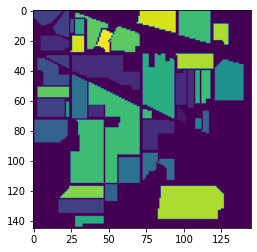

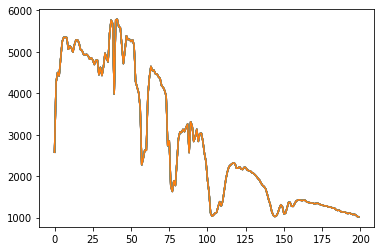

In [41]:
#define 
scene = 'Indian_Pines'
algo_type = 'Supervised'
n = '30'

#50	scale	rbf
#load data
# img, img_gt, img_dr, img_dr_orig = load_data(scene, algo_type, n)

#preprocess data
# img_train, img_gt_train, img_test, img_gt_test, img_dr_train, img_dr_test, img_dr_orig_train, img_dr_orig_test = preprocess(img, img_gt, img_dr, img_dr_orig)

#evaluate metrics on data
# evaluateMetrics(img_train, img_gt_train, img_dr_train, img_dr_test, scene, algo_type) 

#get best metrics after evaluation from CSV
# 1	0.05	poly
C_list = [1]
gamma_list = [0.05]
kernel_list = ['poly']
n_list = list(range(24, 36))
evaluateDim(C_list, gamma_list, kernel_list, n_list, scene , algo_type)

## > CNN

> CNN - Model

In [ ]:
#one hot encoding
img_gt_train_ohe = keras.utils.to_categorical(img_gt_train-1) #Eliminating background class in OHE- i.e. 16 classes now
img_gt_test_ohe = keras.utils.to_categorical(img_gt_test-1)
#sanity check
print(img_gt_train_ohe.shape)

#list to store scores for 5 iterations of model
scores = list()
best_score = 0
#run model for 5 iterations - will consider average
for r in range(5):
    #evaluate and fit model
    [model, score] = cnnFit(r, img_train, img_gt_train_ohe, img_test, img_gt_test_ohe)
    score = score * 100.0

    #get best model from 5 iterations
    if score > best_score:
      best_cnnModel = model
      best_score = score
    # if score>temp_score:
    #   best_cnnModel = model
    #   best_score = score
    # else:

    print('>#%d: %.3f' % (r+1, score))
    #add obtained score to the list
    scores.append(score)

> CNN - Results

In [ ]:
cnnResults(scores, best_cnnModel, best_score, img_train, img_gt_train_ohe, img_test, img_gt_test_ohe)

### > CNN

> CNN - Model

In [ ]:
#one hot encoding
img_gt_train_ohe = keras.utils.to_categorical(img_gt_train-1) #Eliminating background class in OHE- i.e. 16 classes now
img_gt_test_ohe = keras.utils.to_categorical(img_gt_test-1)
#sanity check
print(img_gt_train_ohe.shape)

#list to store scores for 5 iterations of model
scores_dr = list()
best_score_dr = 0
#run model for 5 iterations - will consider average
for r in range(5):
  #evaluate and fit model
  [model, score] = cnnFit(r, img_dr_train, img_gt_train_ohe, img_dr_test, img_gt_test_ohe)
  score = score * 100.0
  #get best model from 5 iterations
  if score > best_score_dr:
    best_cnnModel_dr = model
    best_score_dr = score
    
  print('>#%d: %.3f' % (r+1, score))
  #add obtained score to the list
  scores_dr.append(score)

> CNN - Results

In [ ]:
cnnResults(scores_dr, best_cnnModel_dr, best_score_dr, img_dr_train, img_gt_train_ohe, img_dr_test, img_gt_test_ohe)

In [ ]:
# img_test_new = np.concatenate((img_test, img_bg))
# img_gt_test_new = np.concatenate((ypredicted_svm, img_gt_bg))
# svmScore_new = svmModel.score(img_test_new, img_gt_test++_new)
# print(svmScore_new)
import numpy as np
a = np.load('/content/drive/My Drive/Major_Project/Supervised_Results/reduced_img_f_dr_20.npy')
print(a.shape)

(21025, 20)
